In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [2]:
file_name = "TB_FIRE_1101_hits.root"
hit_data_1101 = rf.get_ROOT_data_zip(file_name)

Folders: ['Hits;1']

Hits:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TLU_number           | uint64_t                 | AsDtype('>u8')
timestamp            | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
plane_ID             | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
ch_ID                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
amplitude            | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
toa                  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...


<span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes

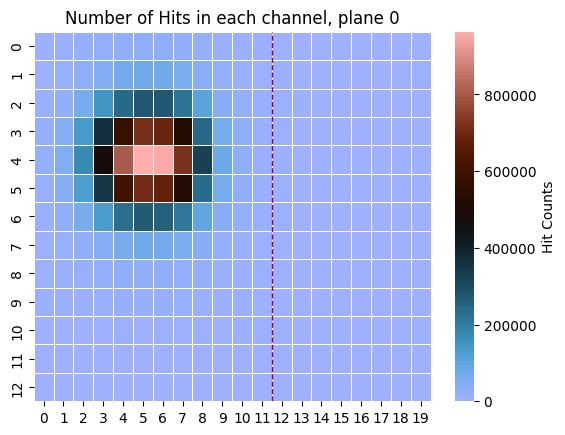

In [3]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 0)

In [4]:
# rf.hits_amount_colormap_single_plane(hit_data_1101, 7)

In [5]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

<span style="font-family: arial; font-size:25px; color:pink">

Shower Evolution Throughout the Sensor

In [25]:
# rf.single_event_evolution_amp(hit_data_1101, 51, cmap="managua")

In [ ]:
def amp_histo_single_plane(hit_data, plane):

    # get the data of the wanted plane
    hit_plane = hit_data[hit_data.plane == plane]

    # create an array of only the amplitudes in the wanted plane
    hit_plane_amp = hit_plane.amp

    # create and plot an histo to count how many time did we get each amp
    counts, bins, patches = plt.hist(ak.flatten(hit_plane_amp), bins=501, range=(0,500))
    max_bin_index = np.argmax(counts)
    peaks, _ = find_peaks(counts)
    peak_x = (bins[peaks] + bins[peaks + 1]) / 2

    # get the most common amp
    max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2
    max_inputs = np.round(max_bin_center)

    # plot settings
    # plt.axvline(max_inputs, color='red', linestyle='--', label= max_inputs)
    colors = ['green', 'blue', 'orange', 'purple']
    for i, px in enumerate(peak_x[:len(colors)]):
        plt.axvline(px, color=colors[i], linestyle='--', linewidth=1, label= np.round(px))
    plt.legend()
    plt.grid(which='major', linestyle='-', linewidth=0.7)
    plt.grid(which='minor', linestyle=':', linewidth=0.5)
    plt.minorticks_on()
    plt.title(f'Amplitude of Hits, plane {plane}', fontsize=16)
    plt.xlabel('Amplitude', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.show()




[    0.     0.     0.     0.     0.     0.   440.  7726. 16768. 34802.
 55006. 71594. 71314. 53467. 35247. 23263. 19207. 16849. 15776. 16182.
 16240. 16130. 16312. 16081. 16471. 16716. 16822. 16699. 16804. 16783.
 16907. 16663. 16377. 16633. 16752. 16114. 15645. 15942. 15252. 14944.
 14842. 14366. 14600. 13893. 13977. 13371. 13279. 12785. 12605. 12084.
 12049. 11825. 11629. 11239. 10902. 10594. 10278. 10154.  9879.  9811.
  9597.  9590.  9383.  9014.  9001.  8638.  8694.  8623.  8220.  8243.
  8043.  7947.  7856.  7562.  7604.  7470.  7261.  7112.  6974.  6796.
  6808.  6655.  6502.  6600.  6489.  6406.  6220.  6091.  6115.  5966.
  5845.  5695.  5726.  5586.  5578.  5395.  5481.  5342.  5186.  5015.
  5075.  4897.  4901.  4823.  4725.  4626.  4699.  4651.  4446.  4378.
  4326.  4454.  4174.  4378.  4262.  4028.  4064.  4043.  3905.  3839.
  3810.  3819.  3849.  3836.  3601.  3580.  3535.  3533.  3424.  3323.
  3413.  3321.  3287.  3347.  3225.  3166.  3071.  3240.  3033.  3000.
  2944

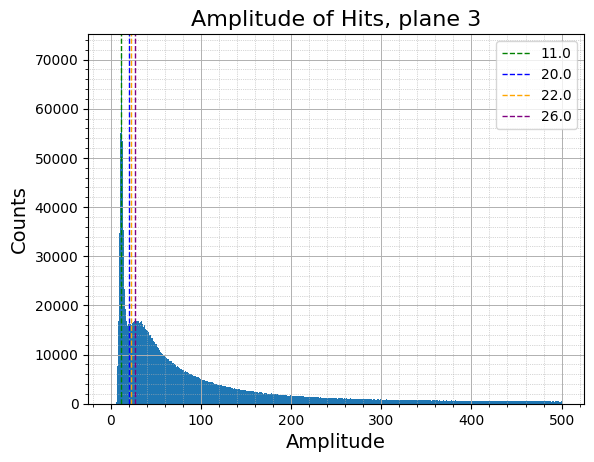

In [45]:
# plt.clf()   # Clear the current figure
plt.close() # Close any open figures
# %matplotlib widget
amp_histo_single_plane(hit_data_1101,3)

In [67]:
# get the reduced energy vs plane in a graph
def average_amp_vs_plane(hit_data):

    # total amount of events in the run(TLU's)
    events = len(hit_data)

    # list of planes
    planes = np.arange(0,8,1)

    # create a list of total energy(amp) for each plane
    plane_avg_amp_list = []
    run_avg_amp_list = []
    plane_hits_amount_list = []

    # get the amp for each plane
    for plane in range(7,-1,-1):
    
        # get only the hits on the wanted plane
        hits_plane_n = hit_data[hit_data.plane == plane]
        hits_plane_n_amp = hits_plane_n.amp
        clean_plane_n_amp = hits_plane_n_amp[ak.num(hits_plane_n_amp) > 0]

        # count the amplitude for every plane
        plane_total_amp = ak.sum(clean_plane_n_amp)             # sum all the amplitudes

        # get the average over all events in the run
        run_avg_amp = plane_total_amp / events
        run_avg_amp_list.append(run_avg_amp)

        # get the average over all the hits in the specific plane
        plane_avg_amp = plane_total_amp / len(clean_plane_n_amp)
        plane_avg_amp_list.append(plane_avg_amp)

        # total amount of hits in each plane
        # plane_hits_amount_list.append(len(clean_plane_n_amp)/1000)
        print(f"amount of hits in plane {7 - plane}:", len(clean_plane_n_amp))

    # print the graph of average energy vs plane

    plt.figure(figsize=(8, 5))
    plt.plot(planes, run_avg_amp_list, marker='o', label = "AMP over events in the run")
    plt.plot(planes, plane_avg_amp_list, marker='v', label = "AMP over hits in plane")
    # plt.scatter(planes, plane_hits_amount_list, marker='d', label = "hits amount in plane")
    plt.xlabel('Plane')
    # plt.ylabel('AMP/(Total Events)')
    plt.title('AMP/total events for each plane')
    plt.grid(True)
    plt.legend()
    plt.show()


        

amount of hits in plane 0: 2154539
amount of hits in plane 1: 2267642
amount of hits in plane 2: 2299936
amount of hits in plane 3: 2305207
amount of hits in plane 4: 287522
amount of hits in plane 5: 2339654
amount of hits in plane 6: 2333522
amount of hits in plane 7: 2347161


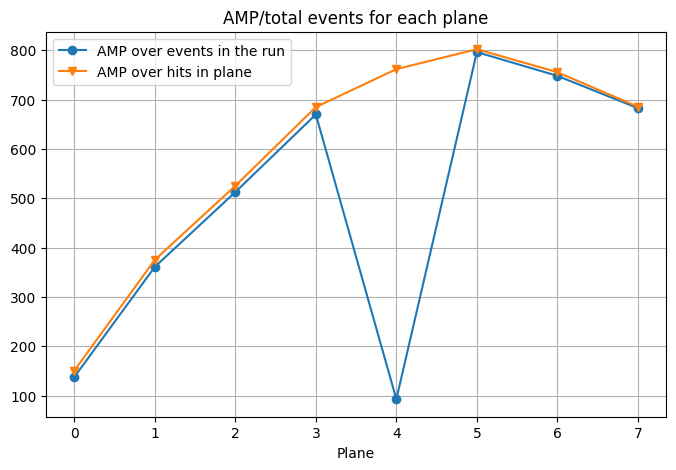

In [68]:
average_amp_vs_plane(hit_data_1101)

In [ ]:
hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

126.87917072170775
319.9437528484798
477.9527983266363
614.3952227138027
685.8192158197353
629.6793203850647
695.0099649525038
594.9684552631945


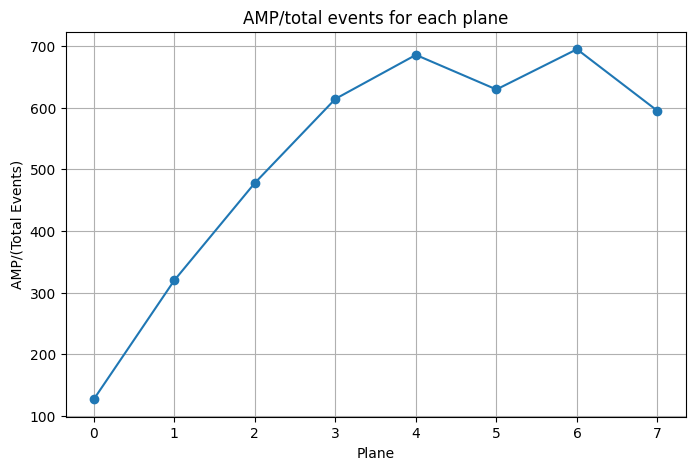

In [41]:
average_amp_vs_plane(hit_data_1096)

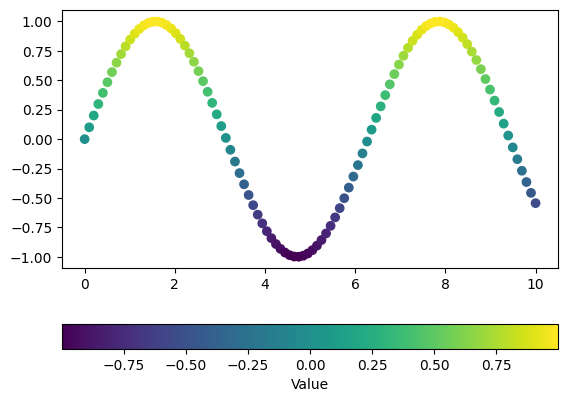

In [71]:
x = np.linspace(0, 10, 100)
y = np.sin(x)
colors = y

sc = plt.scatter(x, y, c=colors, cmap='viridis')
plt.colorbar(sc, orientation='horizontal', label='Value')
plt.show()

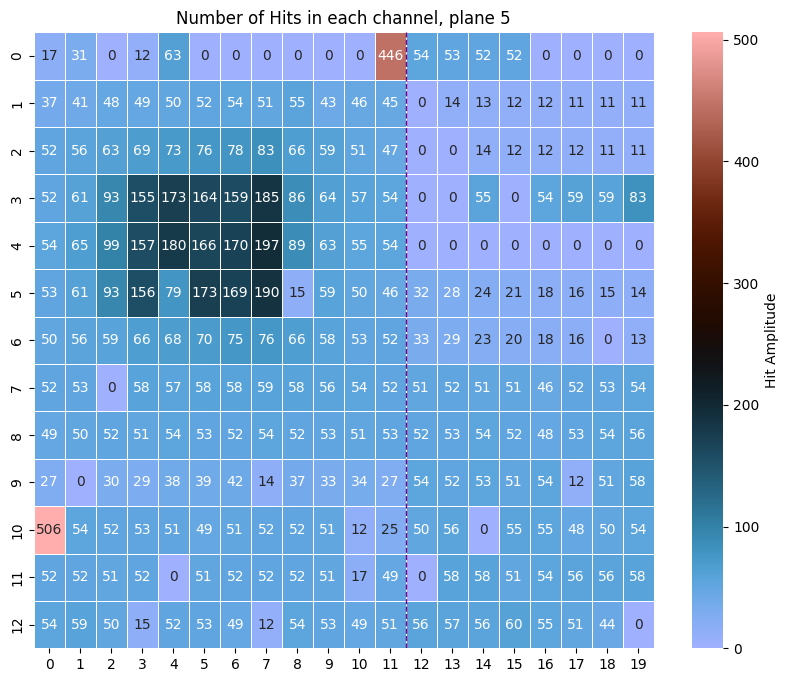

In [13]:
rf.average_amp_colormap_single_plane(hit_data_1101, 5)